# Detection Malicious URL Using ML Models

A URL consists of the top-level domain, hostname, paths, and port of the web
address, as in the following diagram:

![url](https://user-images.githubusercontent.com/70811337/150021474-4ba64b34-1d09-427f-9cf6-25508571d18d.PNG)

<h2 style="width: 100%;
    margin: 0;
    padding: 0;
    text-align: center;">---- Table of contents ----</h2>

1. [Importing Libraries](#1)
2. [Load Dataset](#2)
3. [Meta information of Dataframe](#3)
4. [Checking for NaN values](#4)
5. [Feature Extraction](#5)
6. [Train & Test Split](#6)
7. [Training models](#7)
  <ul>
      <li>✔️ One V/S All Classifier</li>
  </ul>
8. [Final Report](#8)

<a id="1"></a> <br>
# 📥 Importing Libraries

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

<a id="2"></a> <br>
# 🗃️ Load Dataset

In [ ]:
data = pd.read_csv("malicious_phish(1).csv")
data.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


<a id="3"></a> <br>
# 📝 Meta information of Dataframe

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     19999 non-null  object
 1   type    19999 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


<a id="4"></a>
# 🔎 Checking for NaN values

In [ ]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
count = data.type.value_counts()
count

benign        14679
defacement     3649
phishing       1185
malware         486
Name: type, dtype: int64

Text(0, 0.5, 'Count')

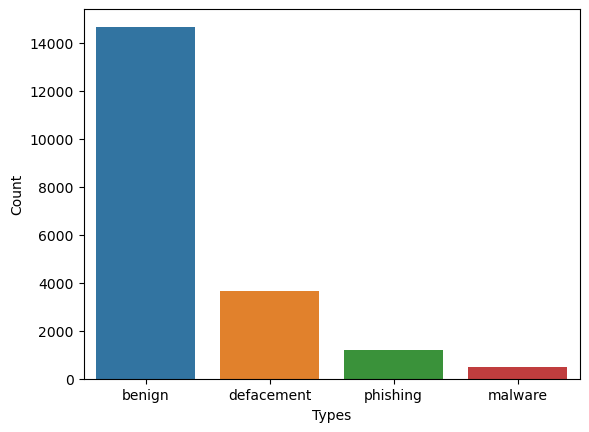

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count')

<h4>first have to omit the (www.) from the URL which is in fact a sub domain in itself.</h4>

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
19994,http://slaviacapital.cz/cenne-papiere/buying-a...,defacement
19995,treasurelore.com/florida/engel_trassen.htm,benign
19996,sfist.com/2008/01/24/pill_hill_stand.php,benign
19997,local.yahoo.com/info-11234383-snowden-house-os...,benign


In [ ]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

<a id="5"></a> <br>
# 🦾 Feature Extraction

In [ ]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [ ]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [ ]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [ ]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

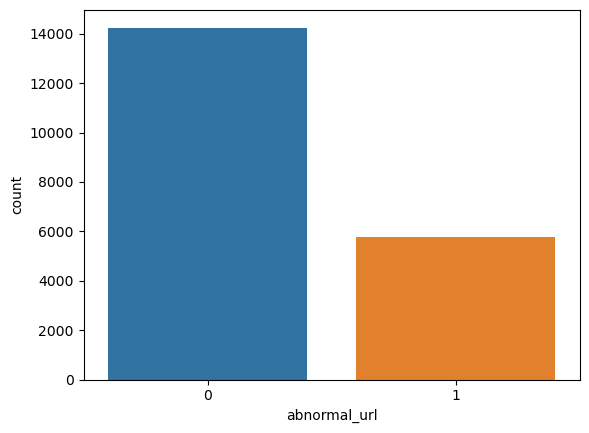

In [ ]:
sns.countplot(x='abnormal_url', data=data);

In [ ]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

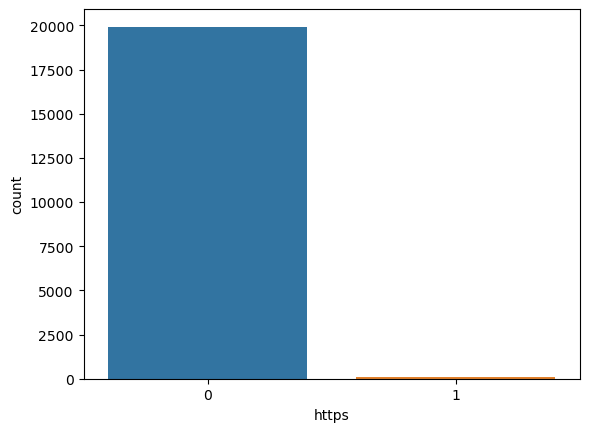

In [ ]:
sns.countplot(x='https', data=data);

<h4>Counts the number of digit characters in a URL</h4>

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

<h4>Counts the number of letter characters in a URL</h4>

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

<h4>Checks to see whether URL contains a shortening service</h4>

In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

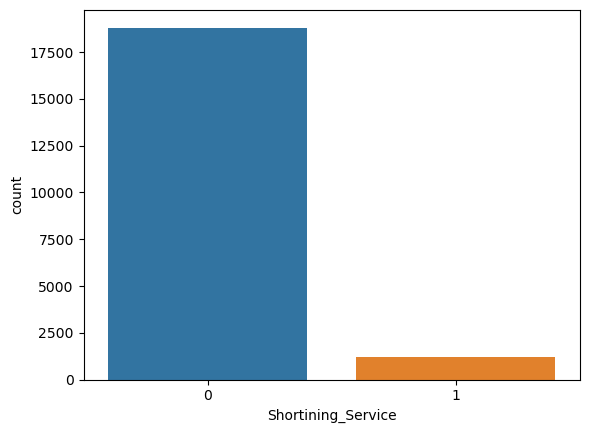

In [ ]:
sns.countplot(x='Shortining_Service', data=data);

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
data['having_ip_address'].value_counts()

0    19985
1       14
Name: having_ip_address, dtype: int64

<AxesSubplot:>

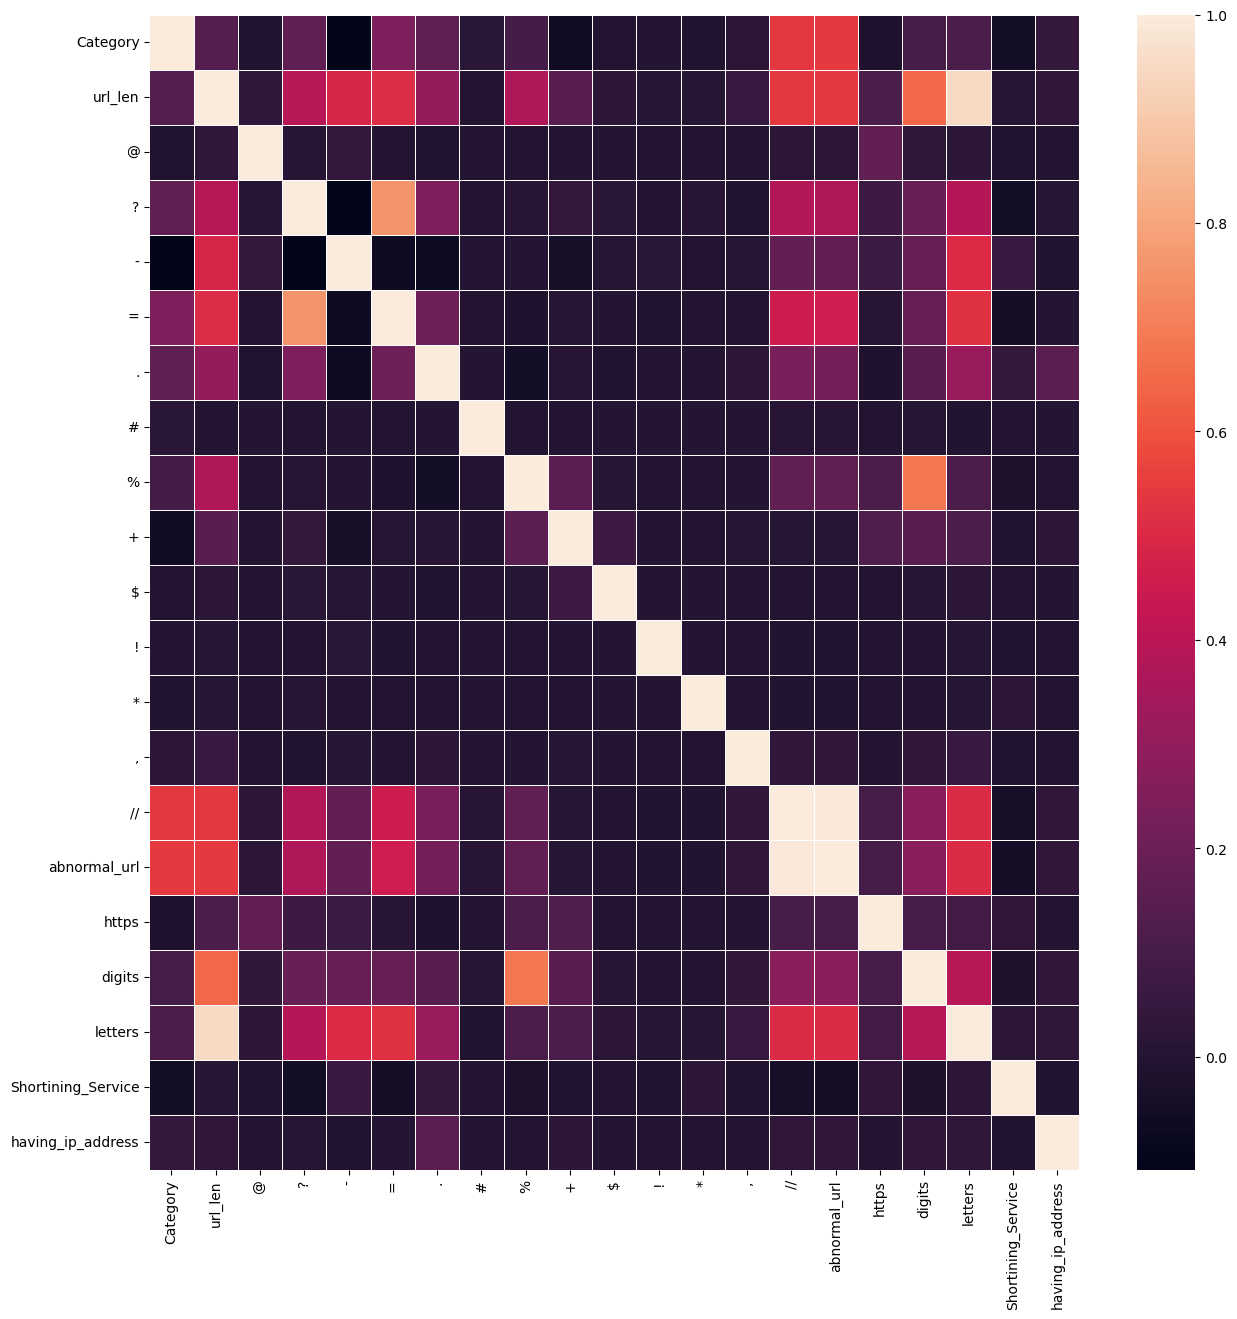

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [ ]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

In [ ]:
X


,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,19,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,17,0,0


<a id="6"></a> <br>
# ✂️ Train & Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
X_test

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
836,50,0,0,1,0,2,0,0,0,0,0,0,0,1,1,0,0,43,0,0
1849,31,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,3,24,0,0
7278,38,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,32,0,0
527,158,0,0,5,0,1,0,38,0,0,0,0,0,1,1,0,45,62,0,0
10432,43,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,9,29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7309,47,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,4,38,0,0
12681,113,0,2,1,2,6,0,0,0,0,0,0,0,3,1,0,2,82,0,0
18928,45,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,39,0,0
19904,66,0,0,3,0,2,0,0,0,0,0,0,0,1,1,0,2,53,0,0


<a id="7"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/32/4149/4149680.png"/> Training models

In [ ]:
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [ ]:
'''model = RandomForestClassifier()
ovr = OneVsRestClassifier(model)
ovr.fit(X_train, y_train)
ovr_pred = ovr.predict(X_test)
acc = accuracy_score(ovr_pred, y_test)
print(acc)'''

'model = RandomForestClassifier()\novr = OneVsRestClassifier(model)\novr.fit(X_train, y_train)\novr_pred = ovr.predict(X_test)\nacc = accuracy_score(ovr_pred, y_test)\nprint(acc)'

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  92.90%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2912
           1       0.93      0.87      0.90       779
           2       0.71      0.70      0.71       223
           3       0.33      0.70      0.45        86

    accuracy                           0.93      4000
   macro avg       0.74      0.81      0.76      4000
weighted avg       0.94      0.93      0.93      4000

             Confusion_matrix 


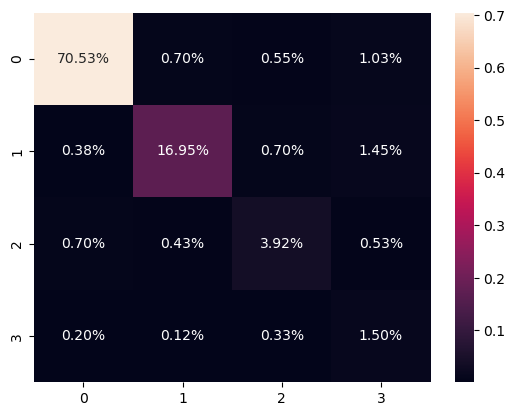

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  95.60%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2912
           1       0.93      0.95      0.94       779
           2       0.86      0.67      0.75       223
           3       0.76      0.64      0.70        86

    accuracy                           0.96      4000
   macro avg       0.88      0.81      0.84      4000
weighted avg       0.95      0.96      0.95      4000

             Confusion_matrix 


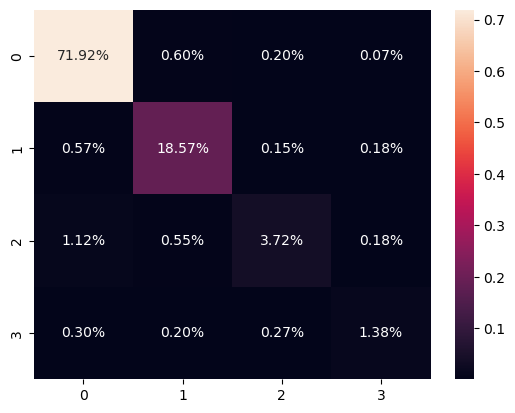

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  91.15%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2912
           1       0.87      0.94      0.90       779
           2       0.69      0.11      0.19       223
           3       0.70      0.44      0.54        86

    accuracy                           0.91      4000
   macro avg       0.80      0.62      0.65      4000
weighted avg       0.90      0.91      0.89      4000

             Confusion_matrix 


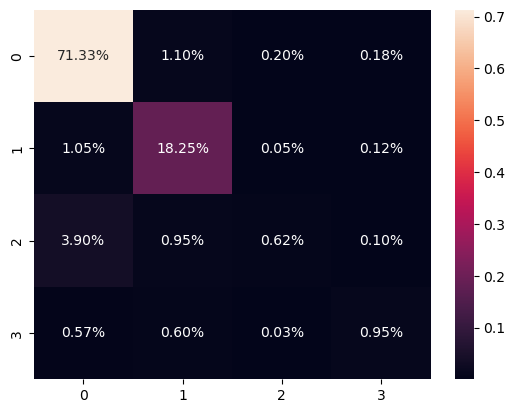

###################- End -###################
#############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  92.10%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2912
           1       0.85      0.90      0.88       779
           2       0.83      0.56      0.66       223
           3       0.77      0.56      0.65        86

    accuracy                           0.92      4000
   macro avg       0.85      0.74      0.79      4000
weighted avg       0.92      0.92      0.92      4000

             Confusion_matrix 


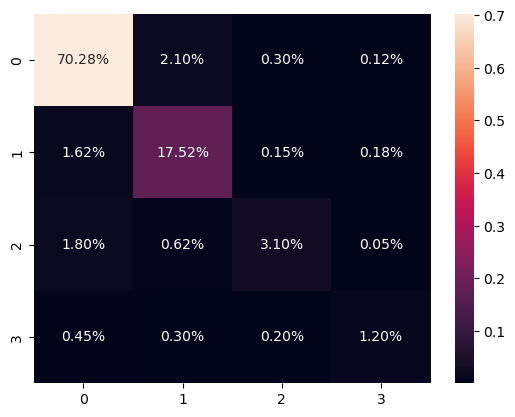

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  87.67%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2912
           1       0.80      0.81      0.81       779
           2       0.14      0.08      0.10       223
           3       0.78      0.29      0.42        86

    accuracy                           0.88      4000
   macro avg       0.66      0.54      0.57      4000
weighted avg       0.86      0.88      0.86      4000

             Confusion_matrix 


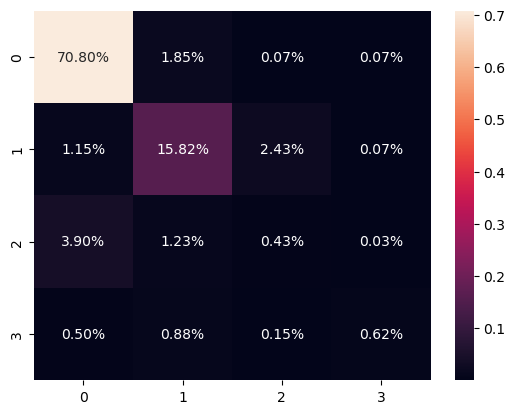

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  95.33%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2912
           1       0.93      0.95      0.94       779
           2       0.81      0.64      0.71       223
           3       0.69      0.66      0.67        86

    accuracy                           0.95      4000
   macro avg       0.85      0.81      0.83      4000
weighted avg       0.95      0.95      0.95      4000

             Confusion_matrix 


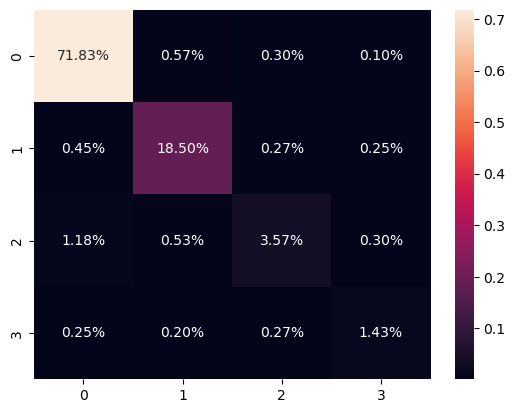

###################- End -###################
#############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  33.60%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.99      0.13      0.23      2912
           1       0.73      0.99      0.84       779
           2       0.07      0.74      0.12       223
           3       0.23      0.29      0.25        86

    accuracy                           0.34      4000
   macro avg       0.50      0.54      0.36      4000
weighted avg       0.87      0.34      0.34      4000

             Confusion_matrix 


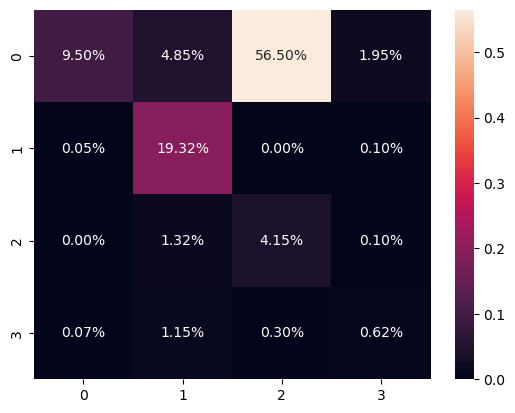

###################- End -###################


In [ ]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,KNeighborsClassifier,SGDClassifier,
         ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    ovr = OneVsRestClassifier(model_)
    ovr.fit(X_train, y_train)
    ovr_pred = ovr.predict(X_test)
    acc = accuracy_score(ovr_pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, ovr_pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, ovr_pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

In [ ]:
binaryClassifier = RandomForestClassifier()
ovr = OneVsRestClassifier(binaryClassifier)
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier())

<a id="8"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/64/3094/3094836.png"/> Final Report

In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','KNeighbors Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})

In [ ]:
output

,Model,Accuracy
0,Decision Tree Classifier,0.92900
1,Random Forest Classifier,0.95600
2,AdaBoost Classifier,0.91150
3,KNeighbors Classifier,0.92100
4,SGD Classifier,0.87675
5,Extra Trees Classifier,0.95325
6,Gaussian NB,0.33600


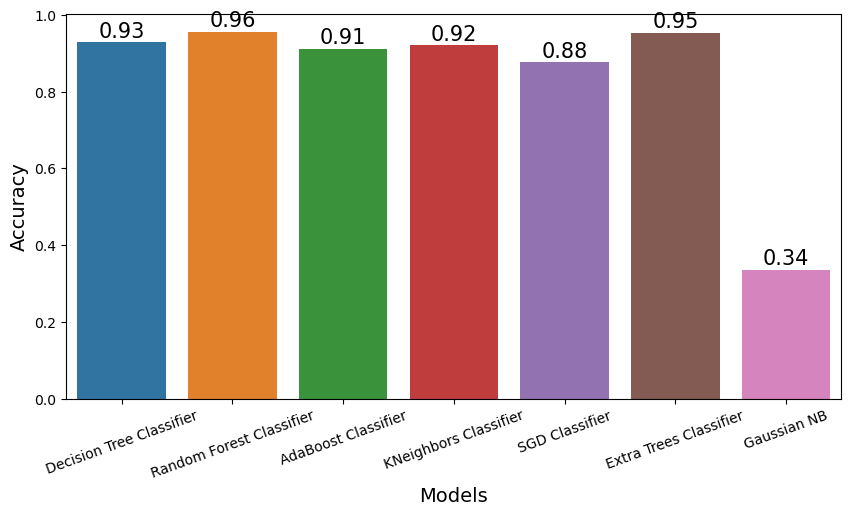

In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [ ]:
import pickle
pickle.dump(ovr, open('model.pkl','wb') )


In [ ]:
model = pickle.load(open('model.pkl','rb'))


In [ ]:
def count(a,url):
    num = url.count(a)
    return num

data = [["onegreatseason.com/"]]
url_data = pd.DataFrame(data,columns=['url'])
url_data['url_len'] = url_data['url'].apply(lambda x: len(str(x)))
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    #url_data[a] = url_data['url'].apply(lambda i: i.count(a))
    val = count(a,str(url_data['url']))
    url_data[a] = val
url_data['abnormal_url'] = url_data['url'].apply(lambda i: abnormal_url(i))
url_data['https'] = url_data['url'].apply(lambda i: httpSecure(i))
url_data['digits']= url_data['url'].apply(lambda i: digit_count(i))
url_data['letters']= url_data['url'].apply(lambda i: letter_count(i))
url_data['Shortining_Service'] = url_data['url'].apply(lambda x: Shortining_Service(x))
url_data['having_ip_address'] = url_data['url'].apply(lambda i: having_ip_address(i))
X = url_data.drop(['url'],axis=1)
output = model.predict(X)
if output == 0:
    print("Safe")

Safe


In [ ]:
def url_feature(url):
    url_data = [[url]]
    url_features = pd.DataFrame(url_data, columns=['url'])
    url_features['url_len'] = url_features['url'].apply(lambda x: len(str(x)))
    feature = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
    for a in feature:
        url_features[a] = url_features['url'].apply(lambda i: str(i).count(a))
    url_features['abnormal_url'] = url_features['url'].apply(lambda i: abnormal_url(i))
    url_features['https'] = url_features['url'].apply(lambda i: httpSecure(i))
    url_features['digits'] = url_features['url'].apply(lambda i: digit_count(i))
    url_features['letters'] = url_features['url'].apply(lambda i: letter_count(i))
    url_features['Shortining_Service'] = url_features['url'].apply(lambda x: Shortining_Service(x))
    url_features['having_ip_address'] = url_features['url'].apply(lambda i: having_ip_address(i))
    '''# Calculate URL length
    url_features['url_len'] = url_features['url'].str.len()

    # Define features to check for in URL
    features = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']

    # Count occurrences of each feature in URL
    for feature in features:
        url_features[feature] = url_features['url'].str.count(feature)

    # Check for abnormal URL
    url_features['abnormal_url'] = abnormal_url(url_features['url'])

    # Check for HTTPS
    url_features['https'] = httpSecure(url_features['url'])

    # Count digits in URL
    url_features['digits'] = digit_count(url_features['url'])

    # Count letters in URL
    url_features['letters'] = letter_count(url_features['url'])

    # Check for Shortening Service
    url_features['Shortining_Service'] = Shortining_Service(url_features['url'])

    # Check for IP address presence
    url_features['having_ip_address'] = having_ip_address(url_features['url'])'''

    X = url_features.drop(['url'], axis=1)
    output = ovr.predict(X)
    return output


In [ ]:
from flask import Flask, request, url_for, redirect, render_template
app = Flask(__name__)
model = pickle.load(open('model.pkl', 'rb'))

'''
def count(a, url):
    num = url.count(a)
    return num


def converting_to_feature(url):
    data = [[url]]
    url_data = pd.DataFrame(data, columns=['url'])
    url_data['url_len'] = url_data['url'].apply(lambda x: len(str(x)))
    feature = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
    for a in feature:
        # url_data[a] = url_data['url'].apply(lambda i: i.count(a))
        val = count(a, str(url))
        url_data[a] = val
    url_data['abnormal_url'] = url_data['url'].apply(lambda i: md.abnormal_url(i))
    url_data['https'] = url_data['url'].apply(lambda i: md.httpSecure(i))
    url_data['digits'] = url_data['url'].apply(lambda i: md.digit_count(i))
    url_data['letters'] = url_data['url'].apply(lambda i: md.letter_count(i))
    url_data['Shortining_Service'] = url_data['url'].apply(lambda x: md.Shortining_Service(x))
    url_data['having_ip_address'] = url_data['url'].apply(lambda i: md.having_ip_address(i))
    X = url_data.drop(['url'], axis=1)
    output = model.predict(X)
    return output'''


@app.route('/')
def hello_world():
    return render_template('Templates\MaliciousURL.html')


@app.route('/predict', methods=['POST', 'GET'])
def predict():
    url = request.form.values()
    output = url_feature(url)
    if output == 0:
        return render_template('Safe to use')
    elif output == 1:
        return render_template('Website altered by external factors')
    elif output == 2:
        return render_template('This url is a phishing url')
    elif output == 3:
        return render_template('This URL contains malware')


if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\guna2\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
